In [1]:
from scipy import io
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Read data and only select overlapping features between CD8+ and CD56 cells

In [2]:
cd8_path = "/Users/jialanma/Downloads/cd8_expression.mtx"
cd8_dat = io.mmread(cd8_path)
cd8_arr = np.array(cd8_dat.todense())
cd8_arr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [3]:
cd56_path = "/Users/jialanma/Downloads/cd56_expression.mtx"
cd56_dat = io.mmread(cd56_path)
cd56_arr = np.array(cd56_dat.todense())
cd56_arr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
cd8_genes = pd.read_csv("/Users/jialanma/Downloads/CD8_gene_names.txt",header=None)
cd56_genes = pd.read_csv("/Users/jialanma/Downloads/CD56_gene_names.txt",header=None)

In [5]:
cd8_genes = np.array(cd8_genes)
cd56_genes = np.array(cd56_genes)

In [6]:
intersect, cd8, cd56 = np.intersect1d(cd8_genes,cd56_genes, return_indices=True)

In [7]:
cd8_filtered = cd8_arr[:,cd8]

In [8]:
cd56_filtered = cd56_arr[:,cd56]

In [58]:
X_train = np.vstack([cd8_filtered[:3000,:],cd56_filtered[:3000,:]])
X_train.shape

(6000, 11937)

In [59]:
y_train = np.hstack([np.ones(3000),np.zeros(3000)])
y_train.shape

(6000,)

In [63]:
X_test = np.vstack([cd8_filtered[3000:,:],cd56_filtered[3000:,:]])
X_test.shape

(12594, 11937)

In [64]:
y_test = np.hstack([np.ones(cd8_filtered.shape[0]-3000),np.zeros(cd56_filtered.shape[0]-3000)])
y_test.shape

(12594,)

In [65]:
X = np.vstack([X_train,X_test])
X.shape

(18594, 11937)

### Pinciple component analysis to reduce feature dimension

In [66]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA

In [67]:
pca = PCA(n_components=100)

In [68]:
X.shape

(18594, 11937)

In [69]:
X_new = pca.fit(X.T)

In [70]:
X_new = X_new.components_
X_new.shape

(100, 18594)

In [71]:
X_new = X_new.T
X_new.shape

(18594, 100)

In [72]:
X_train_new,X_test_new = X_new[:6000,:],X_new[6000:,:]
X_train_new.shape

(6000, 100)

### SVM model


In [73]:
class SVM_modified:
    def __init__(self,C=10,max_iter=10000):
        self.kernel = lambda x1,x2: x1.T @ x2
        self.theta = lambda x1,y1,x2,y2: y1*y2*self.kernel(x1,x2)
        self.C = C
        self.max_iter = max_iter
        
    def get_Q(self,x1,y1,x2,y2):
        theta_11 = self.theta(x1,y1,x1,y1)
        theta_12 = self.theta(x1,y1,x2,y2)
        theta_22 = self.theta(x2,y2,x2,y2)
        
        Q = np.array([[theta_11[0][0],theta_12[0][0]],[theta_12[0][0],theta_22[0][0]]])
        return Q
    
    def get_k0(self,x1,x2,y1,y2,X,y):
        
        y_len = len(y)
        y1_use,y2_use = y1*np.ones(y_len).reshape(-1,1),y2*np.ones(y_len).reshape(-1,1)
        k0_top = self.lambdas.T@self.theta(X.T,y,x1,y1_use)  
        k0_bot = self.lambdas.T@self.theta(X.T,y,x2,y2_use) 
        k0 = np.ones(2).reshape(-1,1)-np.array([k0_top,k0_bot]).reshape(-1,1)

        return k0
    
    def clip_t(self,t_max,v0,u):
        C = self.C
        t_clip1 = (np.clip(v0+t_max*u,0,C)-v0)[1]/u[1]
        t_clip2 = (np.clip(v0+t_clip1*u,0,C)-v0)[0]/u[0]
        
        return t_clip2
        
    def fit(self,X,y):
        self.lambdas = np.zeros(len(y)).reshape(-1,1)
        self.X = X.copy()
        self.y = (2*y - 1).reshape(-1,1) # Convert classes 1 and 0 to +1 and -1
        # self.theta = y1*y2*self.kernel(x1,x2)

        for i in range(self.max_iter):
            for lambda1 in range(len(self.lambdas)):  # iterate over all lambda1
                lambda2 = lambda1
                while lambda1 == lambda2:
                    lambda2 = np.random.randint(0,len(self.lambdas))   # randomly choose lambda2 that is not lambda1
                
                x1 = self.X[lambda1,:].reshape(-1,1) # column vector
                x2 = self.X[lambda2,:].reshape(-1,1) # column vector
                y1 = self.y[lambda1]
                y2 = self.y[lambda2]
       
                Q = self.get_Q(x1,y1,x2,y2)
                v0 = self.lambdas[[lambda1,lambda2]].reshape(-1,1) # column vector
                u = np.array([-y2,y1]).reshape(-1,1)  # column vector
                k0 = self.get_k0(x1,x2,y1,y2,self.X,self.y)
                t_max = (k0.T@u)/(u.T@Q@u + 1e-15)   # add 1e-15 since the denominator is positive-semidefinite (>=0)
                t_clipped = self.clip_t(t_max,v0,u)
                self.lambdas[[lambda1,lambda2]] = v0+u*t_clipped

                
        sv_index = (self.lambdas>1e-15).flatten()  # indices of support vectors
        self.weights = (self.lambdas*self.y).reshape(1,-1)@X
        self.weights = self.weights.reshape(X.shape[1],1)   # feature dimension
        b = self.y[sv_index] - X[sv_index]@self.weights
        self.b = b.mean()

        
    def predict(self,X):
        print(self.b)
        sign = X@self.weights + self.b
        for i in range(len(sign)):
            if sign[i] > 0:
                sign[i] = 1
            else:
                sign[i] = 0
        return sign
        


In [74]:
svm_model = SVM_modified(C=10, max_iter=20)

In [75]:
svm_model.fit(X_train_new,y_train)

In [76]:
predict = svm_model.predict(X_test_new)

0.08990743837171335


### Sklearn SVM

In [77]:
from sklearn import svm

In [78]:
clf = svm.SVC(C=10,kernel='linear')

In [79]:
clf.fit(X_train_new, y_train)

SVC(C=10, kernel='linear')

In [80]:
sk_predict = clf.predict(X_test_new)

### Evaluation

#### Prediction accuracy

In [81]:
m_test = X_test_new.shape[0]

In [82]:
count = 0
for i in range(m_test):
    if predict[i] != y_test[i]:
        count += 1
count

74

In [83]:
predict_accu = (m_test-count)/m_test

In [84]:
print("Prediction Accuracy: ",predict_accu)

Prediction Accuracy:  0.9941241861203748


In [85]:
m_test = X_test_new.shape[0]

In [86]:
sk_count = 0
for i in range(m_test):
    if sk_predict[i] != y_test[i]:
        sk_count += 1
sk_count

86

In [87]:
sk_predict_accu = (m_test-sk_count)/m_test

In [88]:
print("Sklearn Prediction Accuracy: ",sk_predict_accu)

Sklearn Prediction Accuracy:  0.9931713514371923


#### AUC plot

In [89]:
from sklearn import metrics
import matplotlib.pyplot as plt

In [90]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predict, pos_label=1) 

In [91]:
metrics.auc(fpr, tpr)

0.9934579608976862

In [92]:
roc_auc = metrics.auc(fpr, tpr)

In [93]:
sk_fpr, sk_tpr, sk_thresholds = metrics.roc_curve(y_test, sk_predict, pos_label=1) 

In [94]:
metrics.auc(sk_fpr, sk_tpr)

0.9922262909524654

In [95]:
sk_roc_auc = metrics.auc(sk_fpr, sk_tpr)

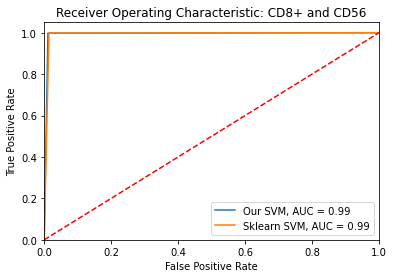

In [96]:
plt.title('Receiver Operating Characteristic: CD8+ and CD56')
plt.plot(fpr, tpr, label = 'Our SVM, AUC = %0.2f' % roc_auc)
plt.plot(sk_fpr, sk_tpr, label = 'Sklearn SVM, AUC = %0.2f' % sk_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Confusion matrix

In [97]:
from sklearn.metrics import confusion_matrix

In [98]:
confu_matrix = confusion_matrix(y_test, predict)

In [99]:
new_count = 0
for i in range(len(y_test)):
    if y_test[i] == predict[i] and y_test[i] == 1:
        new_count += 1
new_count

7195

In [100]:
sk_confu_matrix = confusion_matrix(y_test, sk_predict)

In [101]:
sk_new_count = 0
for i in range(len(y_test)):
    if y_test[i] == sk_predict[i] and y_test[i] == 1:
        sk_new_count += 1
sk_new_count

7200

In [102]:
print("Confusion Matrix:\n")
print("\t","Predicted: CD56", "Predicted: CD8+")
to_print = np.array(["Actual: CD56", "Actual: CD8+"]).reshape(-1,1)
to_print_total = np.hstack([to_print,confu_matrix])
for i in range(to_print_total.shape[0]):
    print(*to_print_total[i,:],sep="\t")

Confusion Matrix:

	 Predicted: CD56 Predicted: CD8+
Actual: CD56	5325	60
Actual: CD8+	14	7195


In [103]:
print("Sklearn Confusion Matrix:\n")
print("\t","Predicted: CD56", "Predicted: CD8+")
sk_to_print = np.array(["Actual: CD56", "Actual: CD8+"]).reshape(-1,1)
sk_to_print_total = np.hstack([to_print,sk_confu_matrix])
for i in range(sk_to_print_total.shape[0]):
    print(*sk_to_print_total[i,:],sep="\t")

Sklearn Confusion Matrix:

	 Predicted: CD56 Predicted: CD8+
Actual: CD56	5308	77
Actual: CD8+	9	7200


#### F1 Score

In [104]:
tn, fp, fn, tp = confusion_matrix(y_test, predict).ravel()
tn, fp, fn, tp

(5325, 60, 14, 7195)

In [105]:
Precision = tp/(tp+fp)
Recall = tp/(tp+fn)
F1 = 2/(1/Precision+1/Recall)
print("F1 Score: ",F1)

F1 Score:  0.9948838495575222


In [106]:
sk_tn, sk_fp, sk_fn, sk_tp = confusion_matrix(y_test, sk_predict).ravel()
sk_tn, sk_fp, sk_fn, sk_tp

(5308, 77, 9, 7200)

In [107]:
sk_Precision = sk_tp/(sk_tp+sk_fp)
sk_Recall = sk_tp/(sk_tp+sk_fn)
sk_F1 = 2/(1/sk_Precision+1/sk_Recall)
print("Sklearn F1 Score: ",sk_F1)

Sklearn F1 Score:  0.9940632334667955
